In [32]:
import numpy as np
from PIL import Image
import wignerdpy
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
import scipy.io as sio
from scipy import signal
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torch import nn
import concurrent.futures

In [33]:
#Importing the data
datasub2 = sio.loadmat('Long_Words/sub_2b_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub3 = sio.loadmat('Long_Words/sub_3b_ch80_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub6 = sio.loadmat('Long_Words/sub_6_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub7 = sio.loadmat('Long_Words/sub_7_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub9 = sio.loadmat('Long_Words/sub_9c_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub11 = sio.loadmat('Long_Words/sub_11b_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

In [34]:
folder_path = {"Long_words": "/home/tseringj/final_project/Long_Words",
               "Short_Long_words": "/home/tseringj/final_project/Short_Long_words",
               "Short_words": "/home/tseringj/final_project/Short_words",
               "Vowels": "/home/tseringj/final_project/Vowels"}

words_dict = {
    "Long_words": ["cooperate", "independent"],
    "Short_Long_words": ["cooperate", "in"],
    "Short_words": ["out", "in", "up"],
    "Vowels": ["a", "i", "u"]
}

numeric_labels = {
    "Long_words": {"cooperate": 0, "independent": 1},
    "Short_Long_words": {"cooperate": 0, "in": 1},
    "Short_words": {"out": 0, "in": 1, "up": 2},
    "Vowels": {"a": 0, "i": 1, "u": 2}
}

In [35]:
row, col=datasub2.shape
print(datasub2[0][0].shape)

(64, 1280)


In [36]:

matrix_to_load = "eeg_data_wrt_task_rep_no_eog_256Hz_last_beep"

def load_EEG(type, subject_no):
    path = folder_path[type]
    words = words_dict[type]
    for subject_file in os.scandir(path):
        if not (subject_file.is_file() and subject_file.name.endswith('.mat') and
                int(re.search("[0-9]+", subject_file.name).group(0)) == subject_no):
            continue
        mat = sio.loadmat(subject_file.path)[matrix_to_load]
        
        temp = f"{path}/temp_files2"
        if not os.path.exists(temp):
            os.mkdir(temp)
        temp = f"{temp}/{subject_no}"

        if not os.path.exists(temp):
            os.mkdir(temp)
        X = []
        Y = []
        for index, eeg in np.ndenumerate(mat):
            temp2 = f"{temp}/{words[index[0]]}_{index[1] + 1}.npy" #storing each trial
            X.append(temp2)
            Y.append(words[index[0]])
            if not os.path.exists(temp2):
                np.save(temp2, eeg)
    return np.array(X), np.array(Y)

In [37]:
type="Long_words"
subject_no=2
X,Y=load_EEG(type, subject_no)

In [38]:
def creating_input(eeg):
    sf=256
    stacked_images = np.empty((256, 256, 0))
    data = np.concatenate([
        eeg[1:9,:],     # electrodes 1 to 8
        eeg[10:17,:],    # electrodes 10 to 31
        eeg[33:49,:]     # electrodes 33 to 62
    ], axis=0)

    # Iterate over the image list
    for i in range(31):


        wigner_dist, max_freq = wignerdpy.wigner_distribution(
                data[i,:], sample_frequency=sf)
        image = wignerdpy.interference_reduced_wigner_distribution(
                wigner_dist)

        image = Image.fromarray(np.uint8(image))




        new_size = (256, 256)  
        image= image.resize(new_size)
        # Expand dimensions to (256, 256, 1)
        expanded_image = np.expand_dims(image, axis=-1)
        # Stack the expanded image along the channel dimension
        stacked_images = np.concatenate((stacked_images, expanded_image), axis=-1)

    # Print the shape of the stacked images
    print(stacked_images.shape)

In [39]:
def get_test_preprocessed_data(X, Y, pre_process, transformer):
    window_size = 256
    stride = 64
    new_X = []
    new_Y = []

    with concurrent.futures.ProcessPoolExecutor(max_workers = int(os.cpu_count()*0.80)) as executor:
        futures = []
        for i in range(len(X)):
            futures.append(executor.submit(
                pre_process, X[i], Y[i],transformer, window_size, stride))
        for future in concurrent.futures.as_completed(futures):
            
            new_X.append(future.result()[0])
            new_Y.append(future.result()[1])
    

    return new_X, new_Y


def test_pre_process(X,Y, transformer,  *arg):
    with open(X, 'rb') as f:
        eeg = np.load(f)
    temp = X.replace(".npy","")
    new_X = f"{temp}_test.npy"
    if not os.path.exists(new_X):
        np.save(new_X, transformer(eeg))
    return new_X, Y

In [40]:
class Test_Dataset(Dataset):

    def __init__(self, X, Y, type):
        
        X, Y = get_test_preprocessed_data(
            X,Y,test_pre_process, creating_input)
        self.X = X
        self.Y = [numeric_labels[type][y] for y in Y]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image=None
        with open(self.X[idx], 'rb') as f:
            image = np.load(f, allow_pickle=True)
            print(image.shape)
            image=image.transpose(2, 0, 1).astype(np.float16)
            # try:
            #     image = np.load(f, allow_pickle=False).transpose(2, 0, 1).astype(np.float32)
            # except ValueError:
            #     image = np.load(f, allow_pickle=True).transpose(2, 0, 1).astype(np.float32)

        return image, self.Y[idx]


def Test_Dataloader(X, Y,  type, batch_size = 2):
    return DataLoader(
        Test_Dataset(X, Y, type),
        batch_size=batch_size,
        shuffle=True,
        num_workers=20,
    )

In [41]:
import copy
import torch.nn as nn
import torch.optim as optim
from torchvision import models
class model_maker(nn.Module):
    def __init__(self, num_classes=None):
        super(model_maker, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(60, 128, kernel_size=3, stride=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # 127*127*128
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 216, kernel_size=7, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)) #32*32*64
        # self.layer3 = nn.Sequential(
        #     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU())
        # self.layer4 = nn.Sequential(
        #     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size = 2, stride = 2)) #16*16*128
        # self.layer5 = nn.Sequential(
        #     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU())
        # self.layer6 = nn.Sequential(
        #     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU())
        # self.layer7 = nn.Sequential(
        #     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size = 2, stride = 2)) #8*8*256
        # self.layer8 = nn.Sequential(
        #     nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU())
        # self.layer9 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU())
        # self.layer10 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size = 2, stride = 2))
        # self.layer11 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU())
        # self.layer12 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU())
        # self.layer13 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(61*61*512, 48),
            nn.ReLU())
        # self.fc1 = nn.Sequential(
        #     nn.Dropout(0.3),
        #     nn.Linear(4096, 512),
        #     nn.ReLU())
        # self.fc2 = nn.Sequential(
        #     nn.Dropout(0.3),
        #     nn.Linear(512, 128),
        #     nn.ReLU())
        self.fc3= nn.Sequential(
            nn.Linear(48, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # out = self.layer3(out)
        # out = self.layer4(out)
        # out = self.layer5(out)
        # out = self.layer6(out)
        # out = self.layer7(out)
        # out = self.layer8(out)
        # out = self.layer9(out)
        # out = self.layer10(out)
        # out = self.layer11(out)
        # out = self.layer12(out)
        # out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        # out = self.fc1(out)
        # out = self.fc2(out)
        out = self.fc3(out)
        return out


def train_model(model, train_loader, val_loader, device, max_epoc=100, patience=30):

    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss = nn.CrossEntropyLoss(reduction = 'sum')
    best_loss = 1
    temp_patience = patience
    for ep in range(max_epoc):

        training_loss = 0
        correct = 0
        model.train()
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            
            optimizer.zero_grad()
            pred = model(X)
            loss_batch = loss(pred, Y)
            correct += (pred.argmax(dim=1) == Y).sum().item()
            training_loss += loss_batch.item()
            loss_batch.backward()
            optimizer.step()

        training_loss = training_loss / len(train_loader.dataset)
        training_acc = correct / len(train_loader.dataset)

        val_loss = 0
        correct = 0
        model.eval()
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            loss_batch = loss(pred, Y)
            correct += (pred.argmax(dim=1) == Y).sum().item()
            val_loss += loss_batch.item()

        validation_acc = correct / len(val_loader.dataset)
        validation_loss = val_loss / len(val_loader.dataset)

        if ep % 5 == 0 or ep == (max_epoc - 1):

            print(f'\t epoch:{ep}, T.acc:{training_acc*100:.3f}, V.acc:{validation_acc*100:.3f}')
            print(f'\t\t T.loss:{training_loss:.5f}, V.loss:{validation_loss:.5f}')


        if validation_loss > best_loss :
            patience -= 1
            if patience <= 0:

                print('Early stopping :(')
                print(f'\t epoch:{ep}, T.acc:{training_acc*100:.3f}, V.acc:{validation_acc*100:.3f}')
                print(f'\t\t T.loss:{training_loss:.5f}, V.loss:{validation_loss:.5f}')
                break
        else:
            best_loss = validation_loss
            patience = temp_patience
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model


def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    loss = nn.CrossEntropyLoss()
    total_loss = 0
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        total_loss += loss(pred, Y) * X.size(0)
        correct += (pred.argmax(dim=1) == Y).sum().item()

    total_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    print(f'Test_fold: Tloss: {total_loss:.5f}, Tacc: {accuracy*100:.3f}')
        
    return accuracy

In [42]:

from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader

In [43]:
def K_fold_evaluation(type,subject_no, batch_size, random_seed):
    # max_split_size_mb = 100
    X,Y=load_EEG(type, subject_no)
    kfolds=10
    #device='cpu'
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.set_device(1)
    skf = StratifiedKFold(
        n_splits=10, random_state=random_seed, shuffle=True)

    score = [0]*kfolds
    for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
        print(f"------------------------fold {i}------------------------")
        # val1=[y for y in Y[train_index] if y=='cooperate'] 
        # val2=[y for y in Y[train_index] if y=='independent']
        # print(len(val1))
        # print(len(val2))
        train_X, val_X, train_Y, val_Y = train_test_split(X[train_index], Y[train_index], test_size=0.2, stratify= Y[train_index], random_state=random_seed)
        test_X, test_Y = X[test_index], Y[test_index]   
        train_loader = Test_Dataloader(train_X, train_Y, type)
        val_loader = Test_Dataloader(val_X, val_Y, type )
        test_loader = Test_Dataloader(test_X, test_Y, type )
        model = model_maker(len(numeric_labels[type]))
        # model = DDP(model, max_split_size=max_split_size_mb)
        model = train_model(model, train_loader, val_loader, device, max_epoc=150)
        score[i] = test_model(model, test_loader, device)
        del model
        torch.cuda.empty_cache() 
    return np.mean(score),np.std(score)

In [44]:
if __name__ == "__main__":
    from datetime import datetime

    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

    

    type="Long_words"
    subject_no=2
    batch_size=4
    random_seed=123
    # with open('results.txt', 'w') as file:
    #     sys.stdout = file
    #     print("time: ", dt_string)
    mean, variance = K_fold_evaluation(type, subject_no, batch_size,random_seed)
    print(f"{subject_no} K-fold mean: ", mean*100)
    print(f"{subject_no} K-fold variance: ", variance*100)

------------------------fold 0------------------------
()
()()()()()()
()

()

()()
()()()()()()()()
()

()
()()()




()


()
()





()()

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/tseringj/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tseringj/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tseringj/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_688690/2669975482.py", line 18, in __getitem__
    image=image.transpose(2, 0, 1).astype(np.float16)
ValueError: axes don't match array



()()



()()()()()()()()()








()


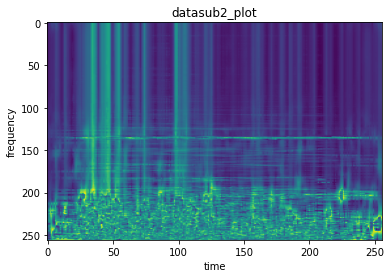

In [ ]:
'''
#For Plotting
def plot_wd(wd, title):
    """Plot the wigner distribution"""
    fig, ax = pyplot.subplots()
    ax.imshow(wd, aspect="auto")
    ax.set_xlabel("time")
    ax.set_ylabel("frequency")
    ax.set_title(title)
    #fig.savefig(title.lower().replace(" ", "_"))
    pyplot.show()
    pyplot.close(fig)
'''


In [ ]:
np.array(wd).shape

(256, 256)